In [2]:
import simulator
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

kwargs = {
    "shape":(6,6),                      # (6 time points, 6 values per timepoint)
    "sample_noise_dist": "uniform",     # ~ U[lower bound, upper bound]
    "signal_func_type": "sigmoid",      
    "noise_func_type": "sigmoid",
    "correlation_type": "pearson"
}

In [ ]:
for i in range(1,10):
    sim = simulator.Simulator(**kwargs)
    timepoints = sim.set_timepoints([0,1,1,0,0,0])
    data = sim.generate_data()
    corr = sim.calculate_correlations()
    plt.scatter(np.linspace(0,5,6), corr)
    
plt.show()

In [ ]:
x_generated = sim.x_range
for i in range(len(data)):
    tpts = sim.timepoints

    if tpts[i] == 0:
        plt.scatter(x_generated, data[i])
    else:
        plt.scatter(x_generated, data[i])

actual_x = np.linspace(30, 70, 40)
actual_y = sim.sigmoid(actual_x, 45, 1)
plt.plot(actual_x, actual_y)

plt.show()

In [14]:
# Actual proteasome correlations
proteasome_corr = pd.read_csv("../data/TPP_proteasome_correlations.csv")

# Filtering for PSMA1 PSMA2 interactions
psma1 = proteasome_corr[proteasome_corr["bait"] == "PSMA1"]
psma1_psma2 = psma1[psma1["prey"] == "PSMA2"]
psma1_psma2.reset_index(inplace=True, drop=True)

In [18]:
psma1_psma2

,bait,prey,t,corr
0,PSMA1,PSMA2,earlyS.median,0.294546
1,PSMA1,PSMA2,lateS.median,-0.468418
2,PSMA1,PSMA2,S_G2.median,-0.119400
3,PSMA1,PSMA2,M.median,0.622651
4,PSMA1,PSMA2,G1.median,0.531029
5,PSMA1,PSMA2,asynch.median,-0.043661


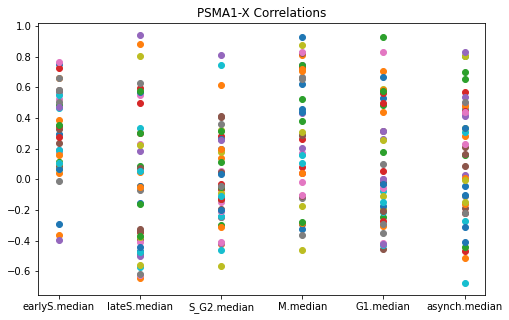

In [25]:
unique_prey = psma1["prey"].unique().tolist()
NUM_PREY = len(unique_prey)

plt.figure(figsize=(8,5))

for i in range(NUM_PREY):
    psma1_prey = psma1[psma1["prey"] == unique_prey[i]]
    psma1_prey.reset_index(inplace=True, drop=True)

    plt.scatter(psma1_prey["t"], psma1_prey["corr"])

plt.title("All PSMA1-X Correlations")
plt.show()